<a href="https://colab.research.google.com/github/rohitsainii/CodSoft/blob/main/Copy_of_Customer_Lifetime_Value_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H2>Customer Lifetime prediction value </H2>

We invest in customers (acquisition costs, offline ads, promotions, discounts & etc.) to generate revenue and be profitable. Naturally, these actions make some customers super valuable in terms of lifetime value but there are always some customers who pull down the profitability. We need to identify these behavior patterns, segment customers and act accordingly.
Calculating Lifetime Value is the easy part. First we need to select a time window. It can be anything like 3, 6, 12, 24 months. By the equation below, we can have Lifetime Value for each customer in that specific time window:

**Lifetime Value: Total Gross Revenue - Total Cost**

This equation now gives us the historical lifetime value. If we see some customers having very high negative lifetime value historically, it could be too late to take an action.

We are going to build a simple machine learning model that predicts our customers lifetime value.

<h3>Lifetime Value Prediction</h3>

* Define an appropriate time frame for Customer Lifetime Value calculation
* Identify the features we are going to use to predict future and create them
* Calculate lifetime value (LTV) for training the machine learning model
* Build and run the machine learning model
* Check if the model is useful

**1. How to decide the timeframe**

Deciding the time frame really depends on your industry, business model, strategy and more. For some industries, 1 year is a very long period while for the others it is very short. In our example, we will go ahead with 6 months.

**2. Identifying the features for prediction**

RFM scores for each customer ID (which we calculated in the previous article) are the perfect candidates for feature set. To implement it correctly, we need to split our dataset. We will take 3 months of data, calculate RFM and use it for predicting next 6 months. So we need to create two dataframes first and append RFM scores to them.

After the first two steps, it is easy to calculate CLTV and train and test the model.

- <a href='#1'>1. Identifying the features</a>  
- <a href='#2'>2. Importing necessary libraries and packages and reading files</a>
   - <a href='#2.1'>2.1 Feature Engineering</a>
- <a href='#3'>3. Recency</a>
   - <a href='#3.1'>3.1 Assigning a recency score </a>
   - <a href='#3.2'>3.2 Ordering clusters</a>
- <a href='#4'> 4. Frequency</a>
   - <a href='#4.1'>4.1 Frequency clusters</a>
- <a href='#5'>5. Revenue</a>
   - <a href='#5.1'>5.1 Revenue clusters</a>
- <a href='#6'>6. Overall score based on RFM Clustering</a>  
- <a href='#7'>7. Customer Lifetime Value </a>
   - <a href='#7.1'>7.1 Feature engineering</a>
- <a href='#8'>8. Machine Learning Model for Customer Lifetime Value Prediction</a>  
- <a href='#9'>9. Final Clusters for Customer Lifetime Value</a>  


<a href=1><h2> 1. Identifying the features </h2></a>

<h3> 2. Importing relevant packages and libraries </h3>

In [ ]:

#import libraries
from __future__ import division

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans


import plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import xgboost as xgb


In [ ]:
#Read data
tx_data = pd.read_csv('/content/customer_segmentation.csv', encoding='cp1252')

In [ ]:
#read data from csv
tx_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


We have all the crucial information we need:
Customer ID
Unit Price
Quantity
Invoice Date
Revenue = Active Customer Count * Order Count * Average Revenue per Order


<a href=2.1><h3>2.1 Feature Engineering </h3></a>

In [ ]:
#converting the type of Invoice Date Field from string to datetime.
tx_data['InvoiceDate'] = pd.to_datetime(tx_data['InvoiceDate'])

In [ ]:
#creating YearMonth field for the ease of reporting and visualization
tx_data['InvoiceYearMonth'] = tx_data['InvoiceDate'].map(lambda date: 100*date.year + date.month)

In [ ]:
tx_data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,InvoiceYearMonth
count,541909.000000,541909,541909.000000,406829.000000,541909.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570,201099.713989
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,201012.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000,201103.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000,201107.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000,201110.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000,201112.000000
std,218.081158,NaN,96.759853,1713.600303,25.788703


In [ ]:
tx_data['Country'].value_counts()

,count
Country,
United Kingdom,495478
Germany,9495
France,8557
EIRE,8196
Spain,2533
Netherlands,2371
Belgium,2069
Switzerland,2002
Portugal,1519


Starting from this part, we will be focusing on UK data only (which has the most records). We can get the monthly active customers by counting unique CustomerIDs. The same analysis can be carried out for customers of other countries as well.

In [ ]:
#we will be using only UK data
tx_uk = tx_data.query("Country=='United Kingdom'").reset_index(drop=True)


**Segmentation Techniques**

You can do many different segmentations according to what you are trying to achieve. If you want to increase retention rate, you can do a segmentation based on churn probability and take actions. But there are very common and useful segmentation methods as well. Now we are going to implement one of them to our business: RFM.
RFM stands for Recency - Frequency - Monetary Value. Theoretically we will have segments like below:

* Low Value: Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
* Mid Value: In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
* High Value: The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

As the methodology, we need to calculate Recency, Frequency and Monetary Value (we will call it Revenue from now on) and apply unsupervised machine learning to identify different groups (clusters) for each. Let’s jump into coding and see how to do RFM Clustering.



<h3><a href=3>3. Recency</a></h3>

To calculate recency, we need to find out most recent purchase date of each customer and see how many days they are inactive for. After having no. of inactive days for each customer, we will apply K-means* clustering to assign customers a recency score.

Lets go ahead and calculate that.

In [ ]:
#create a generic user dataframe to keep CustomerID and new segmentation scores
tx_user = pd.DataFrame(tx_data['CustomerID'].unique())
tx_user.columns = ['CustomerID']
tx_user.head()

,CustomerID
0,17850.0
1,13047.0
2,12583.0
3,13748.0
4,15100.0


In [ ]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012


Since we are calculating recency, we need to know when last the person bought something. Let us calculate the last date of transaction for a person.

In [ ]:
#get the max purchase date for each customer and create a dataframe with it
tx_max_purchase = tx_uk.groupby('CustomerID').InvoiceDate.max().reset_index()
tx_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate
0,12346.0,2011-01-18 10:17:00
1,12747.0,2011-12-07 14:34:00
2,12748.0,2011-12-09 12:20:00
3,12749.0,2011-12-06 09:56:00
4,12820.0,2011-12-06 15:12:00


In [ ]:
# Compare the last transaction of the dataset with last transaction dates of the individual customer IDs.
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days
tx_max_purchase.head()

,CustomerID,MaxPurchaseDate,Recency
0,12346.0,2011-01-18 10:17:00,325
1,12747.0,2011-12-07 14:34:00,1
2,12748.0,2011-12-09 12:20:00,0
3,12749.0,2011-12-06 09:56:00,3
4,12820.0,2011-12-06 15:12:00,2


In [ ]:
#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

,CustomerID,Recency
0,17850.0,301
1,13047.0,31
2,13748.0,95
3,15100.0,329
4,15291.0,25


<a href=3.1><h3> 3.1 Assigning a recency score</h3></a>

We are going to apply K-means clustering to assign a recency score. But we should tell how many clusters we need to K-means algorithm. To find it out, we will apply Elbow Method. Elbow Method simply tells the optimal cluster number for optimal inertia. Code snippet and Inertia graph are as follows:

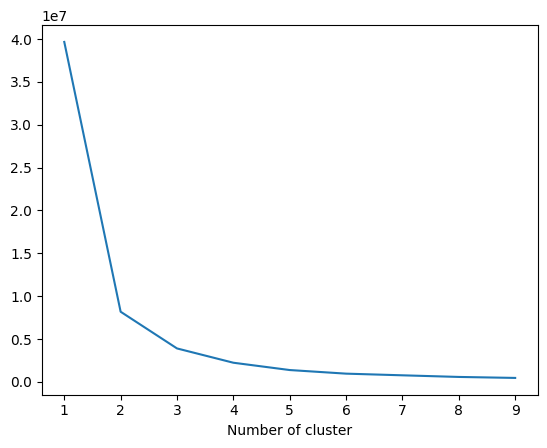

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

Here it looks like 3 is the optimal one. Based on business requirements, we can go ahead with less or more clusters. We will be selecting 4 for this example

In [ ]:
#build 4 clusters for recency and add it to dataframe
kmeans = KMeans(n_clusters=4)
tx_user['RecencyCluster'] = kmeans.fit_predict(tx_user[['Recency']])


In [ ]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,1
1,13047.0,31,0
2,13748.0,95,3
3,15100.0,329,1
4,15291.0,25,0


In [ ]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0
1,478.0,304.393305,41.183489,245.0,266.25,300.0,336.0,373.0
2,570.0,184.436842,31.856230,131.0,156.00,184.0,211.0,244.0
3,952.0,77.567227,22.743569,48.0,59.00,72.0,93.0,130.0


<a href=3.2><h3>3.2 Ordering clusters</a></h3>

We have a cluster corresponding to each customerID. But each cluster is randomly assigned. Cluster 2 is not better than cluster 1 for e.g. and so on. We want to give clusters according to most recent transactions.

We will first find the mean of recency value corresponding to each cluster. Then we will sort these values. Let's say cluster 3 has the most recent transactions mean value. From the above table we see that cluster 1(mean recency 304) > cluster 2 > cluster 3 > cluster 0. That means that cluster 1 is most inactive and cluster 0 is most recent. We will give indices to these clusters as 0,1,2,3. So cluster 1 becomes cluster 0, cluster 2 becomes cluster 1, cluster 3 becomes cluster 2 and so on. Now we will drop the original cluster numbers and replace them with 0,1,2,3. Code is below.

In [ ]:
#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [ ]:
tx_user.head()

,CustomerID,Recency,RecencyCluster
0,17850.0,301,0
1,13047.0,31,3
2,13748.0,95,2
3,15100.0,329,0
4,15291.0,25,3


In [ ]:
tx_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,478.0,304.393305,41.183489,245.0,266.25,300.0,336.0,373.0
1,570.0,184.436842,31.856230,131.0,156.00,184.0,211.0,244.0
2,952.0,77.567227,22.743569,48.0,59.00,72.0,93.0,130.0
3,1950.0,17.488205,13.237058,0.0,6.00,16.0,28.0,47.0


Great! cluster 1 earlier is now cluster0, cluster 2 earlier is now cluster 1 and so on. The clusters are arranged according to inactiviuty. Cluster 0 now is most inactive, cluster 3 is most active.

<h3><a href=4>4. Frequency </a></h3>

To create frequency clusters, we need to find total number orders for each customer. First calculate this and see how frequency look like in our customer database

In [ ]:
#get order counts for each user and create a dataframe with it
tx_frequency = tx_uk.groupby('CustomerID').InvoiceDate.count().reset_index()
tx_frequency.columns = ['CustomerID','Frequency']

In [ ]:
tx_frequency.head() #how many orders does a customer have

,CustomerID,Frequency
0,12346.0,2
1,12747.0,103
2,12748.0,4642
3,12749.0,231
4,12820.0,59


In [ ]:
#add this data to our main dataframe
tx_user = pd.merge(tx_user, tx_frequency, on='CustomerID')

tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency
0,17850.0,301,0,312
1,13047.0,31,3,196
2,13748.0,95,2,28
3,15100.0,329,0,6
4,15291.0,25,3,109


<a href=4.1><h3>4.1 Frequency clusters</h3></a>

Determine the right number of clusters for K-Means by elbow method

/tmp/ipython-input-1409238883.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1409238883.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1409238883.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-140

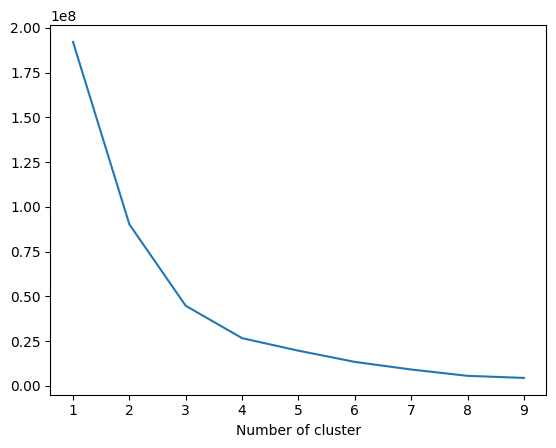

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Frequency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

By Elbow method, clusters number should be 4 as after 4, the graph goes down.

In [ ]:
# Applying k-Means
kmeans=KMeans(n_clusters=4)
tx_user['FrequencyCluster']=kmeans.fit_predict(tx_user[['Frequency']])

#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency', tx_user, True )
tx_user.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,3649.0,56.537682,55.423358,1.0,15.00,35.0,82.0,252.0
1,296.0,447.790541,243.662541,253.0,297.75,364.0,501.0,1857.0
2,4.0,3760.750000,1318.609210,2491.0,2709.25,3712.0,4763.5,5128.0
3,1.0,7983.000000,NaN,7983.0,7983.00,7983.0,7983.0,7983.0


Clsuter with max frequency is cluster 3, least frequency cluster is cluster 0.

<a href=5><h3>5. Revenue</h3></a>

Let’s see how our customer database looks like when we cluster them based on revenue. We will calculate revenue for each customer, plot a histogram and apply the same clustering method.

In [ ]:
#calculate revenue for each customer
tx_uk['Revenue'] = tx_uk['UnitPrice'] * tx_uk['Quantity']
tx_revenue = tx_uk.groupby('CustomerID').Revenue.sum().reset_index()

In [ ]:
tx_revenue.head()

,CustomerID,Revenue
0,12346.0,0.00
1,12747.0,4196.01
2,12748.0,29072.10
3,12749.0,3868.20
4,12820.0,942.34


In [ ]:
#merge it with our main dataframe
tx_user = pd.merge(tx_user, tx_revenue, on='CustomerID')
tx_user.head()


,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,17850.0,301,0,312,1,5288.63
1,13047.0,31,3,196,0,3079.10
2,13748.0,95,2,28,0,948.25
3,15100.0,329,0,6,0,635.10
4,15291.0,25,3,109,0,4596.51


We have some customers with negative revenue as well. Let’s continue and apply k-means clustering:


**Elbow method to find out the optimum number of clusters for K-Means**

/tmp/ipython-input-1926006553.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1926006553.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1926006553.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-192

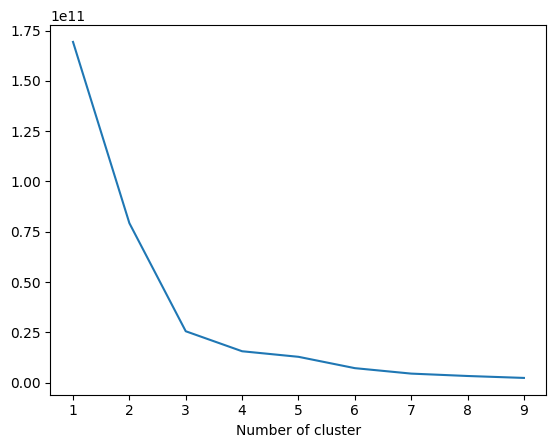

In [ ]:
from sklearn.cluster import KMeans

sse={} # error
tx_recency = tx_user[['Revenue']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(tx_recency)
    tx_recency["clusters"] = kmeans.labels_  #cluster names corresponding to recency values
    sse[k] = kmeans.inertia_ #sse corresponding to clusters
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

From elbow's method, we find that clusters can be 3 or 4. Lets take 4 as the number of clusters

<a href=5.1><h3> 5.1. Revenue clusters </h3></a>

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=4)
tx_user['RevenueCluster'] = kmeans.fit_predict(tx_user[['Revenue']])

#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)

#show details of the dataframe
tx_user.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,3837.0,1091.737981,1297.505328,-4287.63,272.3800,604.51,1400.340,7521.17
1,97.0,13985.478041,7089.548994,7629.38,9065.7600,10930.26,16219.220,33805.69
2,14.0,55597.337857,12190.238571,36351.42,50894.9825,53489.79,58910.975,88125.38
3,2.0,221960.330000,48759.481478,187482.17,204721.2500,221960.33,239199.410,256438.49


Cluster 3 has max revenue, cluster 0 has lowest revenue

<a href=6><h3>6. Overall Score based on RFM Clsutering</h3></a>

We have scores (cluster numbers) for recency, frequency & revenue. Let’s create an overall score out of them


Score 8 is our best customer, score 0 is our worst  customer.

In [ ]:
#calculate overall score and use mean() to see details
tx_user['OverallScore'] = tx_user['RecencyCluster'] + tx_user['FrequencyCluster'] + tx_user['RevenueCluster']
tx_user.groupby('OverallScore')[['Recency','Frequency','Revenue']].mean()

,Recency,Frequency,Revenue
OverallScore,,,
0,304.481092,22.460084,319.268676
1,184.869718,33.804577,523.522643
2,77.988285,49.943557,914.162824
3,19.345664,79.388720,1298.823360
4,12.526749,378.925926,5409.246502
5,6.559322,527.728814,14329.497458
6,5.636364,1325.090909,50699.371818
7,2.500000,2100.750000,140115.227500
8,1.000000,7983.000000,40340.780000


In [ ]:
tx_user['Segment'] = 'Low-Value'
tx_user.loc[tx_user['OverallScore']>2,'Segment'] = 'Mid-Value'
tx_user.loc[tx_user['OverallScore']>4,'Segment'] = 'High-Value'

In [ ]:
tx_user

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value
2,13748.0,95,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,0,6,0,635.10,0,0,Low-Value
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value
...,...,...,...,...,...,...,...,...,...
3945,15471.0,1,3,77,0,469.48,0,3,Mid-Value
3946,13436.0,1,3,12,0,196.89,0,3,Mid-Value
3947,15520.0,1,3,18,0,343.50,0,3,Mid-Value
3948,13298.0,0,3,2,0,360.00,0,3,Mid-Value


<a href=7><h3> 7. Customer Lifetime Value</a></h3>

Since our feature set is ready, let’s calculate 6 months LTV for each customer which we are going to use for training our model.

**Lifetime Value: Total Gross Revenue - Total Cost**

There is no cost specified in the dataset. That’s why Revenue becomes our LTV directly.


In [ ]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
tx_uk['InvoiceDate'].describe()

,InvoiceDate
count,495478
mean,2011-07-04 05:01:41.098131456
min,2010-12-01 08:26:00
25%,2011-03-27 12:06:00
50%,2011-07-19 11:47:00
75%,2011-10-20 10:41:00
max,2011-12-09 12:49:00


We see that customers are active from 1 December 2010. Let us consider customers from March onwards (so that they are not new customers). We shall divide them into 2 subgroups. One will be where timeframe of analysing is 3 months, another will be timeframe of 6 months.

In [ ]:
tx_3m = tx_uk[(tx_uk.InvoiceDate < pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate >= pd.to_datetime(date(2011,3,1)))].reset_index(drop=True) #3 months time
tx_6m = tx_uk[(tx_uk.InvoiceDate >= pd.to_datetime(date(2011,6,1))) & (tx_uk.InvoiceDate < pd.to_datetime(date(2011,12,1)))].reset_index(drop=True) # 6 months time

In [ ]:
#calculate revenue and create a new dataframe for it
tx_6m['Revenue'] = tx_6m['UnitPrice'] * tx_6m['Quantity']
tx_user_6m = tx_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
tx_user_6m.columns = ['CustomerID','m6_Revenue']

In [ ]:
tx_user_6m.head()

,CustomerID,m6_Revenue
0,12747.0,1666.11
1,12748.0,18679.01
2,12749.0,2323.04
3,12820.0,561.53
4,12822.0,918.98


In [ ]:
#plot LTV histogram
plot_data = [
    go.Histogram(
        x=tx_user_6m['m6_Revenue']
    )
]

plot_layout = go.Layout(
        title='6m Revenue'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)
fig.show()

Histogram clearly shows we have customers with negative LTV. We have some outliers too. Filtering out the outliers makes sense to have a proper machine learning model.

Ok, next step. We will merge our 3 months and tx_uk and also merge 6 months dataframe and tx_uk to see correlations between LTV and the feature set we have.

In [ ]:
tx_user.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value
2,13748.0,95,2,28,0,948.25,0,2,Low-Value
3,15100.0,329,0,6,0,635.10,0,0,Low-Value
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value


In [ ]:
tx_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceYearMonth,Revenue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,201012,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,201012,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,201012,20.34


In [ ]:
tx_merge = pd.merge(tx_user, tx_user_6m, on='CustomerID', how='left') #Only people who are in the timeline of tx_user_6m

In [ ]:
tx_merge = tx_merge.fillna(0)


In [ ]:
tx_graph = tx_merge.query("m6_Revenue < 50000") #because max values are ending at 50,000 as seen in graph above

plot_data = [
    go.Scatter(
        x=tx_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=tx_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=tx_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "6m LTV"},
        xaxis= {'title': "RFM Score"},
        title='LTV'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


We can visualise correlation between overall RFM score and revenue. Positive correlation is quite visible here. High RFM score means high LTV.


Before building the machine learning model, we need to identify what is the type of this machine learning problem. LTV itself is a regression problem. A machine learning model can predict the $ value of the LTV. But here, we want LTV segments. Because it makes it more actionable and easy to communicate with other people. By applying K-means clustering, we can identify our existing LTV groups and build segments on top of it.

Considering business part of this analysis, we need to treat customers differently based on their predicted LTV. For this example, we will apply clustering and have 3 segments (number of segments really depends on your business dynamics and goals):
* Low LTV
* Mid LTV
* High LTV

We are going to apply K-means clustering to decide segments and observe their characteristics


In [ ]:
#remove outliers
tx_merge = tx_merge[tx_merge['m6_Revenue']<tx_merge['m6_Revenue'].quantile(0.99)]

In [ ]:
tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01


In [ ]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3)
tx_merge['LTVCluster'] = kmeans.fit_predict(tx_merge[['m6_Revenue']])

tx_merge.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,0
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42,1
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40,0
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00,0
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01,1


In [ ]:
#order cluster number based on LTV
tx_merge = order_cluster('LTVCluster', 'm6_Revenue',tx_merge,True)

#creatinga new cluster dataframe
tx_cluster = tx_merge.copy()

#see details of the clusters
tx_cluster.groupby('LTVCluster')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,2955.0,276.176333,280.962101,-4287.63,0.0000,228.910,449.425,937.60
1,799.0,1605.393279,550.258391,938.20,1143.6650,1479.840,1933.495,3113.70
2,156.0,4645.661795,1345.674897,3129.27,3537.7325,4256.115,5497.980,8432.68


We have finished LTV clustering and here are the characteristics of each clusters as shown above.

Cluster 2 is the best with average 8.2k LTV whereas 0 is the worst with 396.

There are few more step before training the machine learning model:
* Feature engineering.
* Convert categorical columns to numerical columns.
* We will check the correlation of features against our label, LTV clusters.
* We will split our feature set and label (LTV) as X and y. We use X to predict y.
* Will create Training and Test dataset. Training set will be used for building the machine learning model. We will apply our model to Test set to see its real performance.


In [ ]:
tx_cluster.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,m6_Revenue,LTVCluster
0,17850.0,301,0,312,1,5288.63,0,1,Low-Value,0.00,0
1,13047.0,31,3,196,0,3079.10,0,3,Mid-Value,1425.42,1
2,13748.0,95,2,28,0,948.25,0,2,Low-Value,367.40,0
3,15100.0,329,0,6,0,635.10,0,0,Low-Value,0.00,0
4,15291.0,25,3,109,0,4596.51,0,3,Mid-Value,1980.01,1


<a href = 7.1> <h3>7.1 Feature Engineering</h3></a>

In [ ]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(tx_cluster) #There is only one categorical variable segment
tx_class.head()

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVCluster,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
0,17850.0,301,0,312,1,5288.63,0,1,0.00,0,False,True,False
1,13047.0,31,3,196,0,3079.10,0,3,1425.42,1,False,False,True
2,13748.0,95,2,28,0,948.25,0,2,367.40,0,False,True,False
3,15100.0,329,0,6,0,635.10,0,0,0.00,0,False,True,False
4,15291.0,25,3,109,0,4596.51,0,3,1980.01,1,False,False,True


In [ ]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)


,LTVCluster
LTVCluster,1.000000
m6_Revenue,0.877508
Revenue,0.774841
Frequency,0.569080
OverallScore,0.475296
FrequencyCluster,0.469650
RevenueCluster,0.409227
RecencyCluster,0.359270
Segment_High-Value,0.342884
Segment_Mid-Value,0.291954


In [ ]:
#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','m6_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=56)

We see that Revenue, Frequency and RFM scores will be helpful for our machine learning models from the correlation with LTVCluster.


<A href = 8><h3> 8. Machine Learning Model for Customer Lifetime Value Prediction</h3> </a>

Since our LTV Clusters are 3 types, high LTV, mid LTV and low LTV; we will perform multi class classification.

In [ ]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test[X_train.columns], y_test)))

y_pred = ltv_xgb_model.predict(X_test)


Accuracy of XGB classifier on training set: 0.95
Accuracy of XGB classifier on test set: 0.90


Accuracy looks good on training and test set. Let's check the precision, recall, fscore too

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       156
           1       0.68      0.76      0.72        34
           2       0.60      0.50      0.55         6

    accuracy                           0.90       196
   macro avg       0.75      0.74      0.74       196
weighted avg       0.90      0.90      0.90       196



<a href=9> <h2>9. Final Clusters for Customer Lifetime Value </h2></a>

- **Cluster 0**: Good precision, recall, f1-score and support
- **Cluster 1**: Needs better precision, recall and f1-score
- **Cluster 2**: Bad precision, F1-Score needs improvement

If model tells us this customer belongs to cluster 0, 93 out of 100 will be correct (precision). And the model successfully identifies 95% of actual cluster 0 customers (recall).

We really need to improve the model for other clusters. For example, we barely detect 67% of Mid LTV customers.

**Possible actions to improve performance**

- Adding more features and improve feature engineering
- Try different models other than XGBoost
- Apply hyper parameter tuning to current model
- Add more data to the model if possible


In [ ]:
# Function to predict LTV cluster for a new customer
def predict_ltv_cluster(model, customer_data):
    """
    Predicts the LTV cluster for a new customer.

    Args:
        model: The trained machine learning model.
        customer_data: A pandas DataFrame with the same columns as the training data,
                       containing the features of the new customer.

    Returns:
        The predicted LTV cluster.
    """
    prediction = model.predict(customer_data)
    return prediction[0]

# Example usage:
# Create a DataFrame with the new customer's data.
# Make sure the column names and order match the training data (X_train).
# You will need to replace the values with the actual data for your customer.
new_customer_data = pd.DataFrame({
    'CustomerID': [12345.0],
    'Recency': [10],
    'RecencyCluster': [3],
    'Frequency': [50],
    'FrequencyCluster': [1],
    'Revenue': [1000.0],
    'RevenueCluster': [2],
    'OverallScore': [6],
    'Segment_High-Value': [False],
    'Segment_Low-Value': [False],
    'Segment_Mid-Value': [True]
})

# Predict the LTV cluster for the new customer
predicted_cluster = predict_ltv_cluster(ltv_xgb_model, new_customer_data[X_train.columns])

print(f"The predicted LTV cluster for the new customer is: {predicted_cluster}")

# Map the cluster number to the segment
cluster_to_segment = {
    0: 'Low LTV',
    1: 'Mid LTV',
    2: 'High LTV'
}

print(f"The predicted LTV segment for the new customer is: {cluster_to_segment.get(predicted_cluster, 'Unknown')}")

The predicted LTV cluster for the new customer is: 1
The predicted LTV segment for the new customer is: Mid LTV
